In [1]:
# https://cs231n.stanford.edu/slides/2016/winter1516_lecture9.pdf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [4]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./inp/mnist', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./inp/mnist', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Training samples: 60000
Test samples: 10000


In [5]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool1 = nn.AvgPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.pool2 = nn.AvgPool2d(2, 2)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.tanh(self.conv1(x))
    x = self.pool1(x)
    x = F.tanh(self.conv2(x))
    x = self.pool2(x)
    x = x.view(-1, 16*5*5)
    x = F.tanh(self.fc1(x))
    x = F.tanh(self.fc2(x))
    x = self.fc3(x)
    return x

model = LeNet5().to(device)
model

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:
model.train()
epochs = 3

for epoch in range(epochs):
  running_loss = 0.0
  progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
  for images, labels in progress_bar:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
  print(f"Epoch [{epoch+1}/{epochs}] - Avg Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/3] - Avg Loss: 0.2408


Epoch [2/3] - Avg Loss: 0.0701


Epoch [3/3] - Avg Loss: 0.0494


In [8]:
activations = []
all_labels = []
def get_activation():
  def hook(model, input, output):
    activations.append(output.detach().cpu())
  return hook
handle = model.fc1.register_forward_hook(get_activation())

model.eval()
correct = 0
total = 0
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    all_labels.append(labels.cpu())
handle.remove()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 98.61%


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 0.182s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 4.258856
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.987015
[t-SNE] KL divergence after 1000 iterations: 1.501630


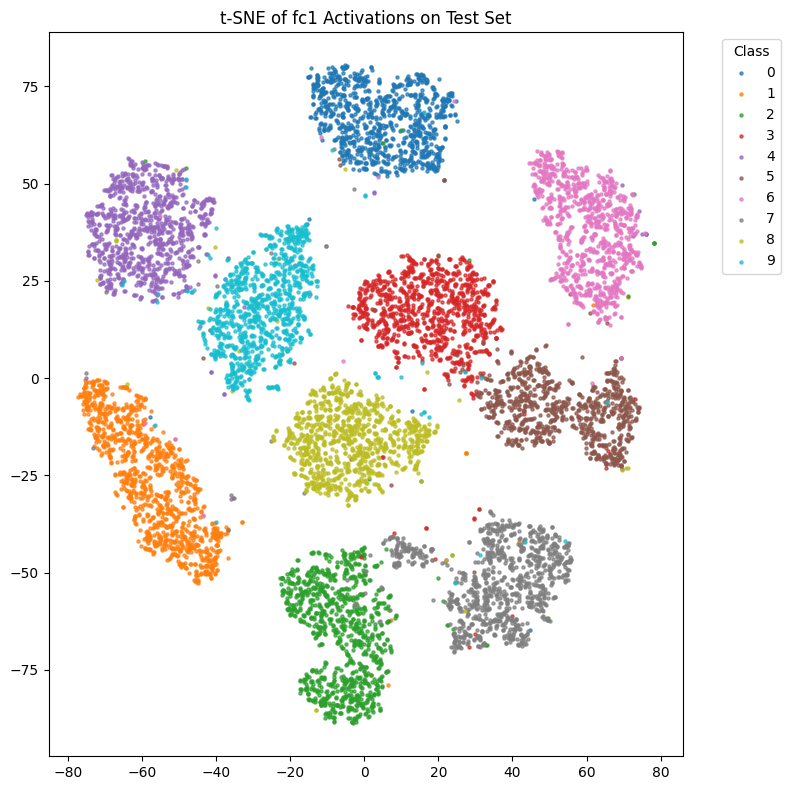

In [9]:
activations_tensor = torch.cat(activations, dim=0)
labels_tensor = torch.cat(all_labels, dim=0)

tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="random", max_iter=1000, verbose=1)
X_2d = tsne.fit_transform(activations_tensor.numpy())

plt.figure(figsize=(8, 8))
num_classes = len(torch.unique(labels_tensor))

for c in range(num_classes):
  idx = labels_tensor.numpy() == c
  plt.scatter(X_2d[idx, 0], X_2d[idx, 1], s=5, label=str(c), alpha=0.7)

plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE of fc1 Activations on Test Set")
plt.tight_layout()
plt.show()